In [8]:
import matplotlib.pyplot as plt
import wordcloud
from os import path
import logging
import io
import collections
import re
import nltk
import numpy as np
from PIL import Image

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

logger = logging.getLogger('FraudEmails')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jseme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jseme\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
try:
    with open('fraudulent-email-corpus/fradulent_emails.txt','r') as file:
        text = io.open('fraudulent-email-corpus/fradulent_emails.txt').read()
except Exception as e:
    logger.error('Process failed with error: '+repr(e))
finally:
    file.close()

#Delete everything between From r [.*?] Status: RO
formatEmails = re.sub('From.*?Status: ?O','',text,flags=re.DOTALL)


In [10]:
formatEmails = formatEmails.lower()

formatEmails = ''.join([i for i in formatEmails if not i.isdigit()])


formatEmailsList = nltk.word_tokenize(formatEmails)

In [11]:
#Correspond every entry to tag from https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
tags = nltk.pos_tag(formatEmailsList)


In [12]:
#Keep JJ (adjectives), NN (singular nouns), NNS (plural nouns)

toKeep = ['JJ','NN','NNS']
forWordCloud = []

for tag in tags:
    if tag[1] in toKeep:
        forWordCloud.append(tag[0])


In [13]:
#Remove math equations/nonsense/single letters
scamDict = collections.Counter(forWordCloud)
toRemove = ['i','br','%','nbsp','=','<','>','div','sum','mr.','http','other','charset=','dear']
for removal in toRemove:
    del scamDict[removal]

#Remove less than 200 instances
scamDict = {k: v for k, v in scamDict.items() if v > 100}


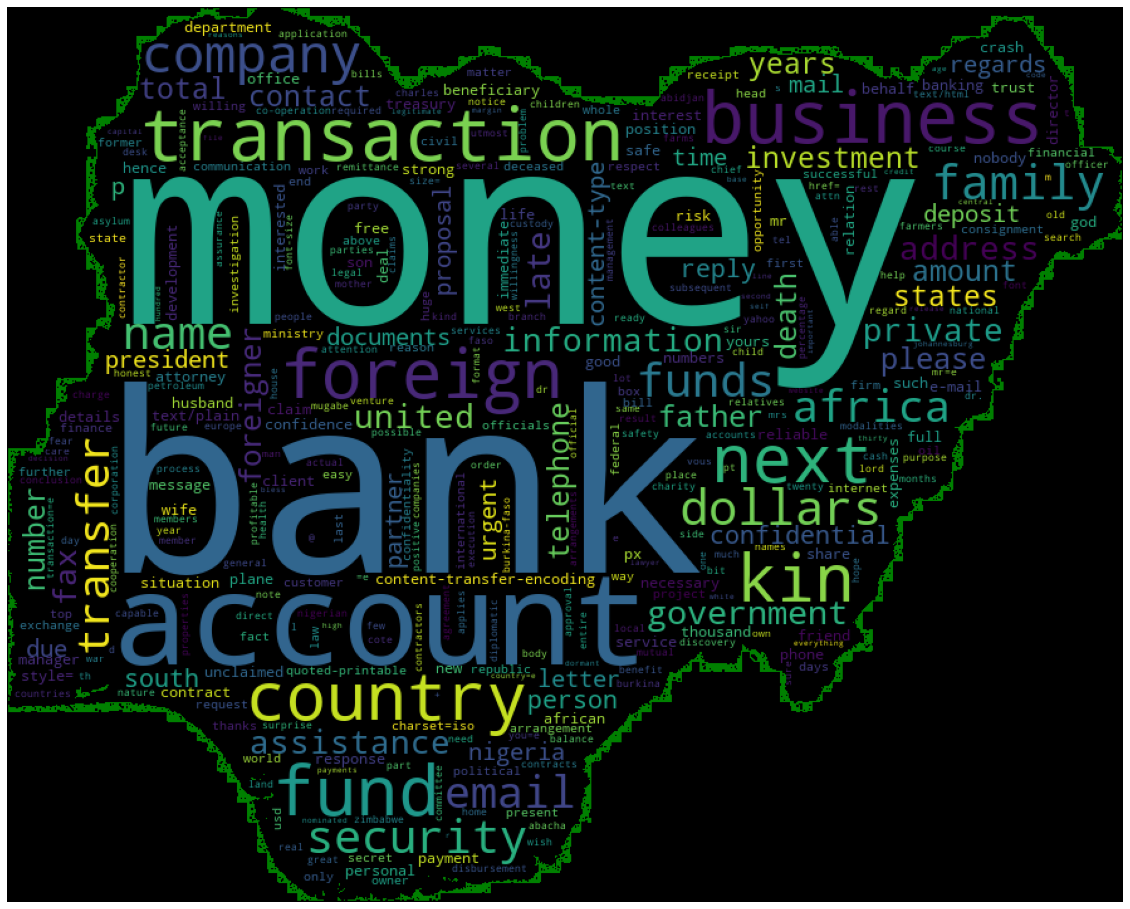

In [19]:

nigeriaMask = np.array(Image.open('NigeriaOutline.jpg'))
scamCloud = wordcloud.WordCloud(width=800,height=800,
                                max_words=400,mask=nigeriaMask,
                                contour_width=1,contour_color='green').generate_from_frequencies(scamDict)


#scamCloud.to_file('NigeriaScamWordCloud.png')
plt.figure(figsize=(20,20))
plt.imshow(scamCloud)
plt.axis("off")
plt.savefig('NigeriaScamWordCloud.png',bbox_inches='tight',pad_inches=0)